In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import math
import json
import numpy as np
import jax
import jax.numpy as jnp
import flax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import timecast as tc
import sklearn
import sklearn.linear_model
import sklearn.decomposition

from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [103]:
jnp = np

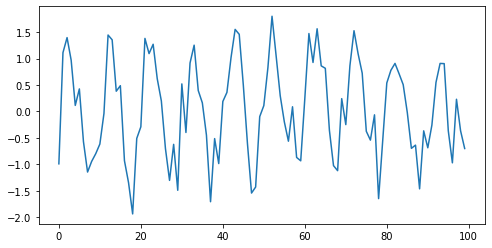

In [104]:
# data generator sinusoid + white noise
plt.rc('figure', figsize=(8,4))

def datagen(length, period, noise_level, seed):
    t = np.linspace(0, length-1, length)
    x = np.sin(2*np.pi/period * t)
    noise = jax.random.normal(jax.random.PRNGKey(seed), (length,)) * noise_level
    return x + noise

x = datagen(100,10,0.5,0)
plt.plot(x)

(80, 20) (80,)


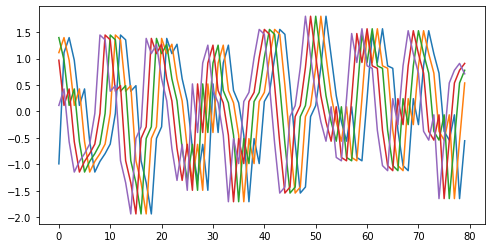

In [105]:
# generate sliding windows
plt.rc('figure', figsize=(8,4))

def AR_feat(x, H):
  X, Y = [], []
  for i in range(H, len(x)):
    X.append(x[i-H:i])
    Y.append(x[i])
  return np.array(X), np.array(Y)

X, Y = AR_feat(x, 20)
print(X.shape, Y.shape)
for i in range(5):
  plt.plot(X[:,i])

In [106]:
train_length = 1000
test_length = 1000
period = 10
noise_level = 0.5

x_train = datagen(train_length, period, noise_level, 0)
x_test = datagen(test_length, period, noise_level, 3)

In [107]:
def viz(truth, pred, title, **kwargs):
    plt.title(title)
    plt.plot(truth, color='gray')
    plt.plot(np.arange(len(truth)-len(pred), len(truth)), pred, **kwargs)

def trunc_mse(truth, pred):
  # compute truncated MSE, with shorter array of predictions
  return np.mean( (truth[len(truth)-len(pred):]-pred)**2 )

/home/dsuo/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dsuo/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


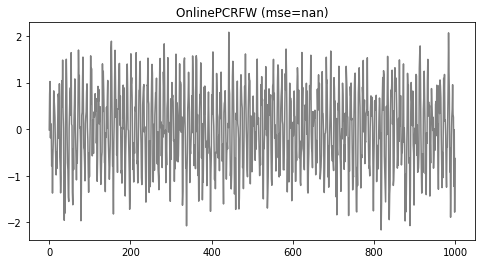

In [108]:
# OnlinePCR, Frank-Wolfe

"""
𝛂 (jnp.ndarray): a vector of length W
x (jnp.ndarray): true values from 0 to W - 1
𝛘 (jnp.ndarray): W histories with d * H dimensions
B (jnp.ndarray): Projection matrix from d * H dimensions to d * H dimensions
𝜆 (float): regularization factor

𝜑(𝛂, B) = 𝓁(-𝜆 * W * 𝛂, x) / W + 𝜆 / 2 * 𝛂.T @ 𝛘 @ B @ 𝛘.T @ 𝛂

d𝜑(𝛂, B)/d𝛂 = (-𝜆 * W * 𝛂 - x) / W + 𝜆 * 𝛘 @ B @ 𝛘.T @ 𝛂
            = 0
            
𝛂 = (I - 𝛘 @ B @ 𝛘.T)^-1 @ (-x / (W * 𝜆))
"""

def min_𝛂(x, 𝛘, B, W, 𝜆):
    XBX = 𝛘 @ B @ 𝛘.T
    inv = jnp.linalg.pinv(jnp.eye(XBX.shape[0]) - XBX)
    return inv @ (-x / (W * 𝜆))

def grad_phi_B(𝛂, 𝛘, 𝜆):
    return - 𝜆 / 2 * jnp.outer(𝛂 @ 𝛘, 𝛂 @ 𝛘)

def grad_F_B(B, G, 𝛽, 𝜂, B0):
    return 𝜂 * G + 𝛽 * (B - B0)

def TestOnlinePCRFW(x_train, x_test, H, W):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
    
    d = 1
    C = 1
    B = jnp.eye(d * H)
    B0 = B
    G = jnp.zeros_like(B0)
    𝜆 = 1000

    T = X_test.shape[0]
    
    Y_pred = []
    
    for t in tqdm.tqdm(range(W, T)):
        eigvals, eigvecs = jnp.linalg.eigh(B)
        M = eigvecs @ jnp.diag(jnp.sqrt(eigvals)) @ eigvecs.T
#         M = B
        
        ls = sklearn.linear_model.Ridge(𝜆)
        ls.fit(X_test[t - W:t] @ M.T, Y_test[t - W:t])
        
        Y_pred.append(ls.predict(X_test[t].reshape(1, -1))[0])
        
        𝛂 = min_𝛂(Y_test[t - W + 1:t + 1], X_test[t - W + 1:t + 1], B, W, 𝜆)
        
        g = grad_phi_B(𝛂, X_test[t - W + 1 : t + 1], 𝜆)
        G += g
        
        FB = grad_F_B(B, G, 4 / (𝜆 * (t ** 1/4)), 1 / jnp.sqrt(t + 1), B0)
        
        eigvals, eigvecs = jax.scipy.linalg.eigh(-FB)
        v = eigvecs[np.argmax(eigvals)]
        
        𝛾 = 1 / t
        B = 𝛾 * C * jnp.outer(v, v) + (1 - 𝛾) * B
        
        print(jnp.linalg.norm(G), trunc_mse(Y_test[:len(Y_pred)], Y_pred))
        
    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='OnlinePCRFW (mse=%.3f)' % err, color='green')
    return err, Y_pred

err, Y_pred = TestOnlinePCRFW(x_train, x_test, H, W)

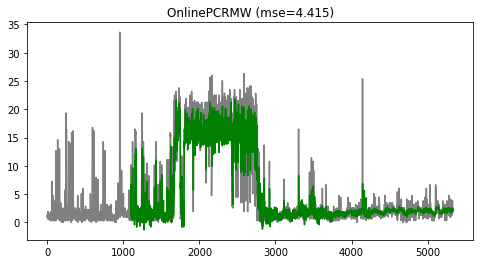

In [125]:
# OnlinePCR, MW

"""
𝛂 (jnp.ndarray): a vector of length W
x (jnp.ndarray): true values from 0 to W - 1
𝛘 (jnp.ndarray): W histories with d * H dimensions
B (jnp.ndarray): Projection matrix from d * H dimensions to d * H dimensions
𝜆 (float): regularization factor

𝜑(𝛂, B) = 𝓁(-𝜆 * W * 𝛂, x) / W + 𝜆 / 2 * 𝛂.T @ 𝛘 @ B @ 𝛘.T @ 𝛂

d𝜑(𝛂, B)/d𝛂 = (-𝜆 * W * 𝛂 - x) / W + 𝜆 * 𝛘 @ B @ 𝛘.T @ 𝛂
            = 0
            
𝛂 = (I - 𝛘 @ B @ 𝛘.T)^-1 @ (-x / (W * 𝜆))
"""

def min_𝛂(x, 𝛘, B, W, 𝜆):
    XBX = 𝛘 @ B @ 𝛘.T
    inv = jnp.linalg.pinv(jnp.eye(XBX.shape[0]) - XBX)
    return inv @ (-x / (W * 𝜆))

def grad_f_B(𝛂, 𝛘, 𝜆):
    return - 𝜆 / 2 * jnp.outer(𝛂 @ 𝛘, 𝛂 @ 𝛘)

def TestOnlinePCRMW(x_train, x_test, H, W):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
    
    d = 1
    C = 1
    B = jnp.eye(d * H)
    P = jnp.zeros_like(B)
    𝜆 = 1000

    T = X_test.shape[0]
    
    𝜂 = 𝜆 / jnp.sqrt(T)
    𝜂 = 0
    
    Y_pred = []
    
    for t in tqdm.tqdm(range(W, T)):
        eigvals, eigvecs = jnp.linalg.eigh(B)
        M = eigvecs @ jnp.diag(jnp.sqrt(eigvals)) @ eigvecs.T

        ls = sklearn.linear_model.Ridge(𝜆)
        ls.fit(X_test[t - W:t] @ M.T, Y_test[t - W:t])
        
        Y_pred.append(ls.predict(X_test[t].reshape(1, -1))[0])
        
        𝛂 = min_𝛂(Y_test[t - W + 1:t + 1], X_test[t - W + 1:t + 1], B, W, 𝜆)
        
        p = grad_f_B(𝛂, X_test[t - W + 1 : t + 1], 𝜆)
        P += p
        eigvals, eigvecs = jnp.linalg.eigh(P)
        
        exp = jnp.exp(-𝜂 * eigvals)
        
        v = eigvecs @ jnp.diag(exp) @ eigvecs.T
        B = v / exp.sum()
        
    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='OnlinePCRMW (mse=%.3f)' % err, color='green')
    return err, Y_pred

err, Y_pred = TestOnlinePCRMW(x_train, x_test, H, W)

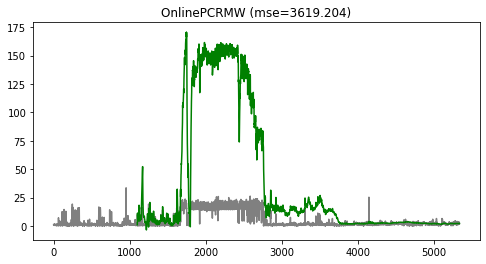

In [126]:
# OnlinePCR, MW

"""
𝛂 (jnp.ndarray): a vector of length W
x (jnp.ndarray): true values from 0 to W - 1
𝛘 (jnp.ndarray): W histories with d * H dimensions
B (jnp.ndarray): Projection matrix from d * H dimensions to d * H dimensions
𝜆 (float): regularization factor

𝜑(𝛂, B) = 𝓁(-𝜆 * W * 𝛂, x) / W + 𝜆 / 2 * 𝛂.T @ 𝛘 @ B @ 𝛘.T @ 𝛂

d𝜑(𝛂, B)/d𝛂 = (-𝜆 * W * 𝛂 - x) / W + 𝜆 * 𝛘 @ B @ 𝛘.T @ 𝛂
            = 0
            
𝛂 = (I - 𝛘 @ B @ 𝛘.T)^-1 @ (-x / (W * 𝜆))
"""

def min_𝛂(x, 𝛘, B, W, 𝜆):
    XBX = 𝛘 @ B @ 𝛘.T
    inv = jnp.linalg.pinv(jnp.eye(XBX.shape[0]) - XBX)
    return inv @ (-x / (W * 𝜆))

def grad_f_B(𝛂, 𝛘, 𝜆):
    return - 𝜆 / 2 * jnp.outer(𝛂 @ 𝛘, 𝛂 @ 𝛘)

def TestOnlinePCRMW(x_train, x_test, H, W):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
    
    d = 1
    C = 1
    B = jnp.eye(d * H)
    P = jnp.zeros_like(B)
    𝜆 = 1000

    T = X_test.shape[0]
    
    𝜂 = 𝜆 / jnp.sqrt(T)
    𝜂 = 0
    
    Y_pred = []
    
    for t in tqdm.tqdm(range(W, T)):
        eigvals, eigvecs = jnp.linalg.eigh(B)
        M = eigvecs @ jnp.diag(jnp.sqrt(eigvals)) @ eigvecs.T

        ls = sklearn.linear_model.Ridge(𝜆)
        ls.fit(X_test[t - W:t] @ M.T, Y_test[t - W:t])
        
        Y_pred.append(ls.predict(X_test[t].reshape(1, -1))[0])
        
        𝛂 = min_𝛂(Y_test[t - W + 1:t + 1], X_test[t - W + 1:t + 1], B, W, 𝜆)
        
        p = grad_f_B(𝛂, X_test[t - W + 1 : t + 1], 𝜆)
        P += p
        eigvals, eigvecs = jnp.linalg.eigh(P)
        
        exp = jnp.exp(-𝜂 * eigvals)
        
        v = eigvecs @ jnp.diag(exp) @ eigvecs.T
        B = v / exp.sum()
        
    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='OnlinePCRMW (mse=%.3f)' % err, color='green')
    return err, Y_pred

err, Y_pred = TestOnlinePCRMW(x_train, x_test, H, W)

In [92]:
# Least Squares AR
plt.rc('figure', figsize=(8,4))

def TestLeastSquaresAR(x_train, x_test, H):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
    
    ls = None
    if X_train.shape[0] > 0:
        ls = sklearn.linear_model.Ridge(1e-20)
        ls.fit(X_train, Y_train)
    
    Y_pred = []
    for x, y in tqdm.tqdm(zip(X_test, Y_test)):
        X_train, Y_train = list(X_train), list(Y_train)
        
        pred = y if ls is None else ls.predict(x.reshape(1, -1))
        Y_pred.append(pred)
        
        X_train.append(x)
        Y_train.append(y)
        ls = sklearn.linear_model.Ridge(1e-20)
        
        X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)
        ls.fit(X_train, Y_train)
        
        print(trunc_mse(Y_test[:len(Y_pred)], np.asarray(Y_pred).flatten()))

    err = trunc_mse(Y_test, np.array(Y_pred).squeeze())
    viz(x_test, Y_pred, title='LeastSquaresAR (mse=%.3f)' % err, color='lime')

    return err, Y_pred

In [110]:
data = pd.read_csv('../data/tspdb/LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:21]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
data_3 = data_2.groupby(['time']).agg(agg_dict)
print('data aggregated..')

data loaded..
data aggregated..


In [111]:
# cutoff = 25968
cutoff = 20968
# cutoff = 0
# x_train = np.array(data_3.iloc[:cutoff]).sum(axis=1)
# x_test = np.array(data_3.iloc[cutoff:]).sum(axis=1)

x_train = np.array(data_3.iloc[:cutoff])[:, 0]
x_test = np.array(data_3.iloc[cutoff:])[:, 0]

H = 100

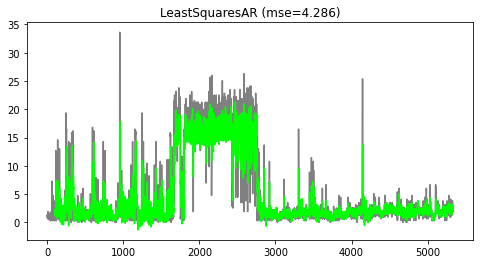

In [71]:
loss_least_squares_ar, ar_pred = TestLeastSquaresAR(x_train, x_test, H)

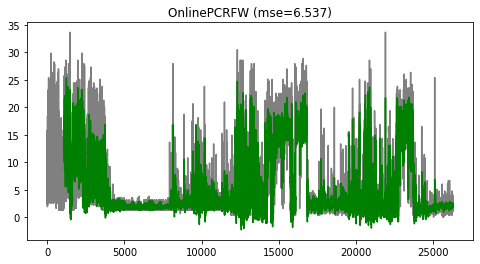

In [91]:
W = 1000
# lambda = 1e-20

loss_online_pcr_fw, fw_pred = TestOnlinePCRFW(x_train, x_test, H, W)

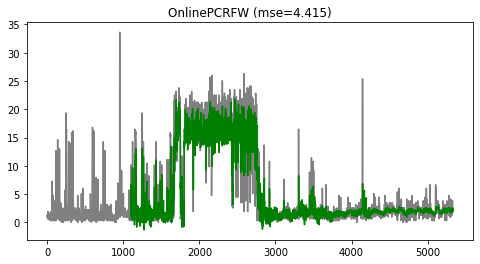

In [89]:
W = 1000
# lambda = 1000

loss_online_pcr_fw, fw_pred = TestOnlinePCRFW(x_train, x_test, H, W)

In [86]:
X_test, Y_test = AR_feat(x_test, H)

trunc_mse(Y_test[1000:], np.array(ar_pred[1000:]).flatten())

4.03235507747961

In [ ]:
loss_table.append( [loss_least_squares_ar,
                    loss_online_pcr_fw] )

loss_table = np.array(loss_table)
plt.tight_layout()